In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

# Sentiment Analysis Using BERT (Bidirectional Encoder Representations from Transformers)

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install transformers

### Loading Dataset and EDA

In [ ]:
# Load the dataset
df = pd.read_csv('/content/sentiment.csv')  # Replace with the actual path to your dataset



In [ ]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Let's have a look at the data
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,27-10-2020 21:24,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,27-10-2020 14:03,"Please note that from checking our records, yo...",27-10-2020 15:05,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,27-10-2020 08:18,NaN,NaN,newest,com.anydo
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,NaN,26-10-2020 13:28,What do you find troublesome about the update?...,26-10-2020 14:58,newest,com.anydo
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,26-10-2020 06:10,NaN,NaN,newest,com.anydo


In [ ]:
# Let's check for missing values
df.isnull().sum()

,0
reviewId,0
userName,0
userImage,0
content,0
score,0
thumbsUpCount,0
reviewCreatedVersion,1023
at,0
replyContent,2503
repliedAt,2503


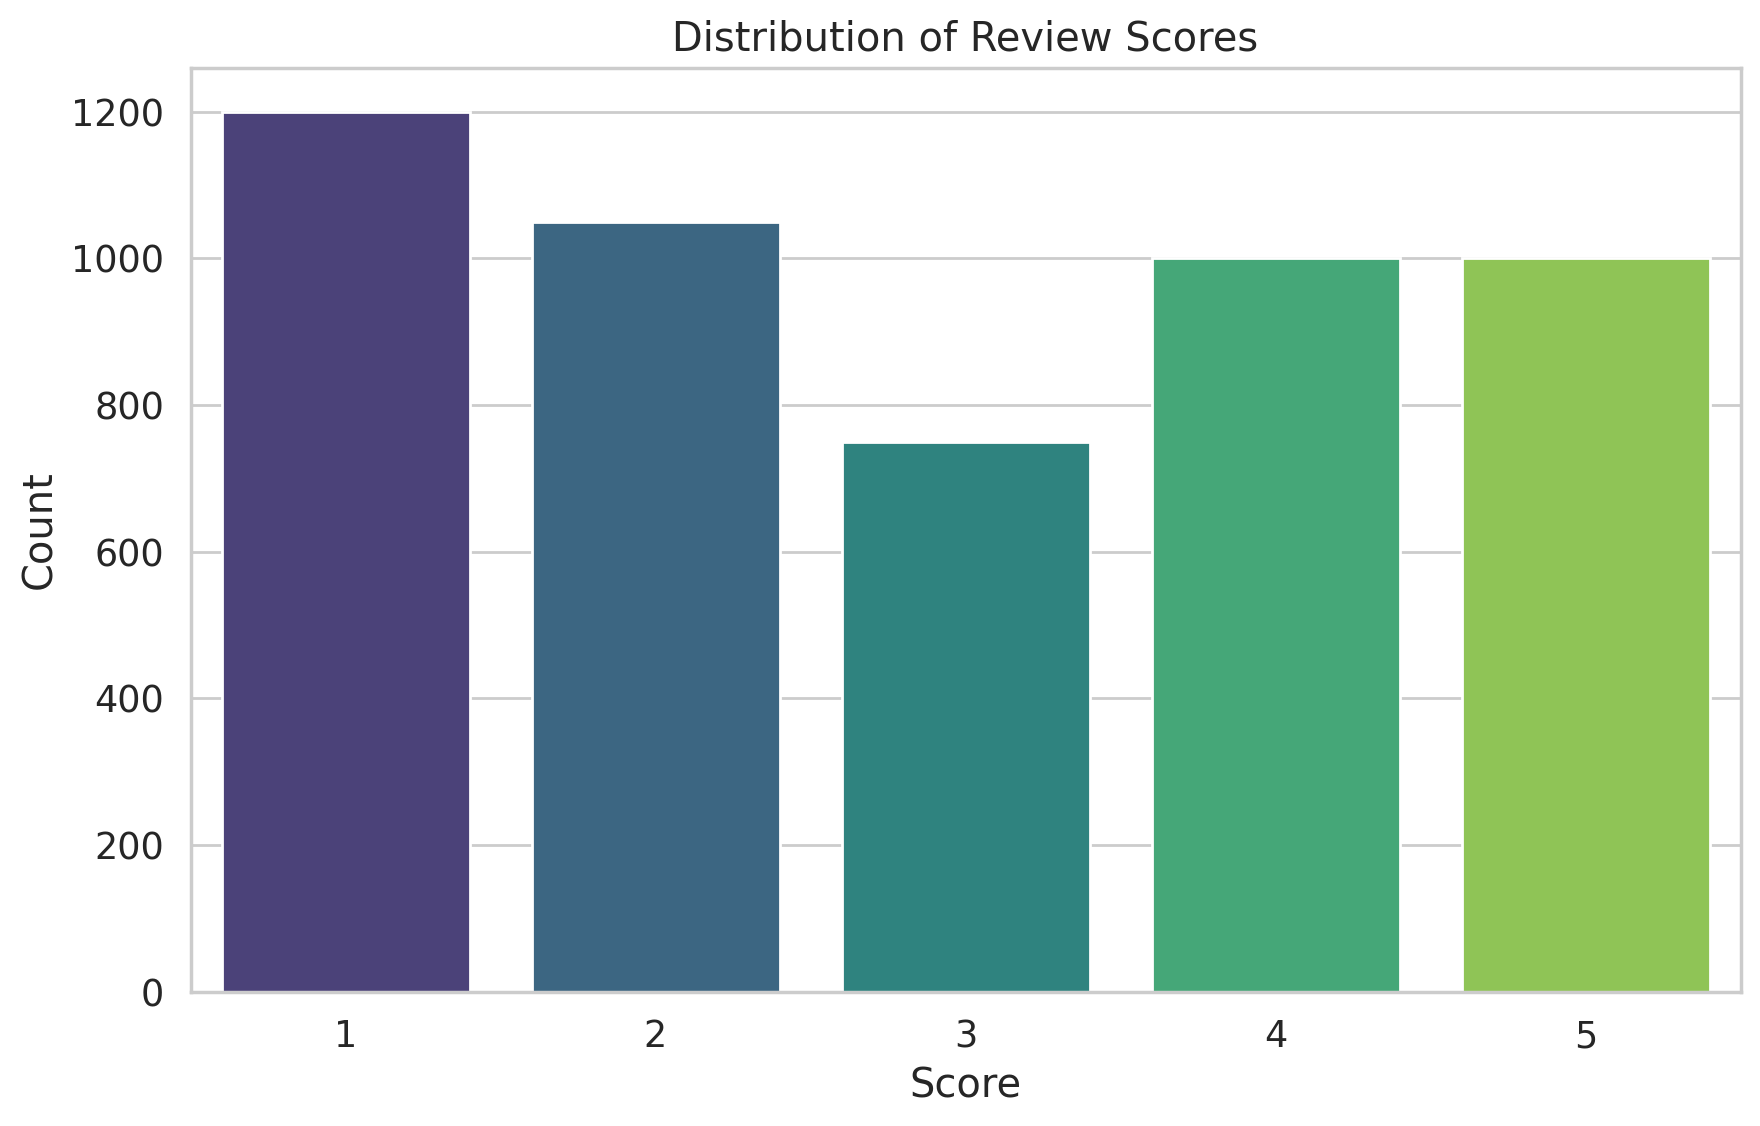

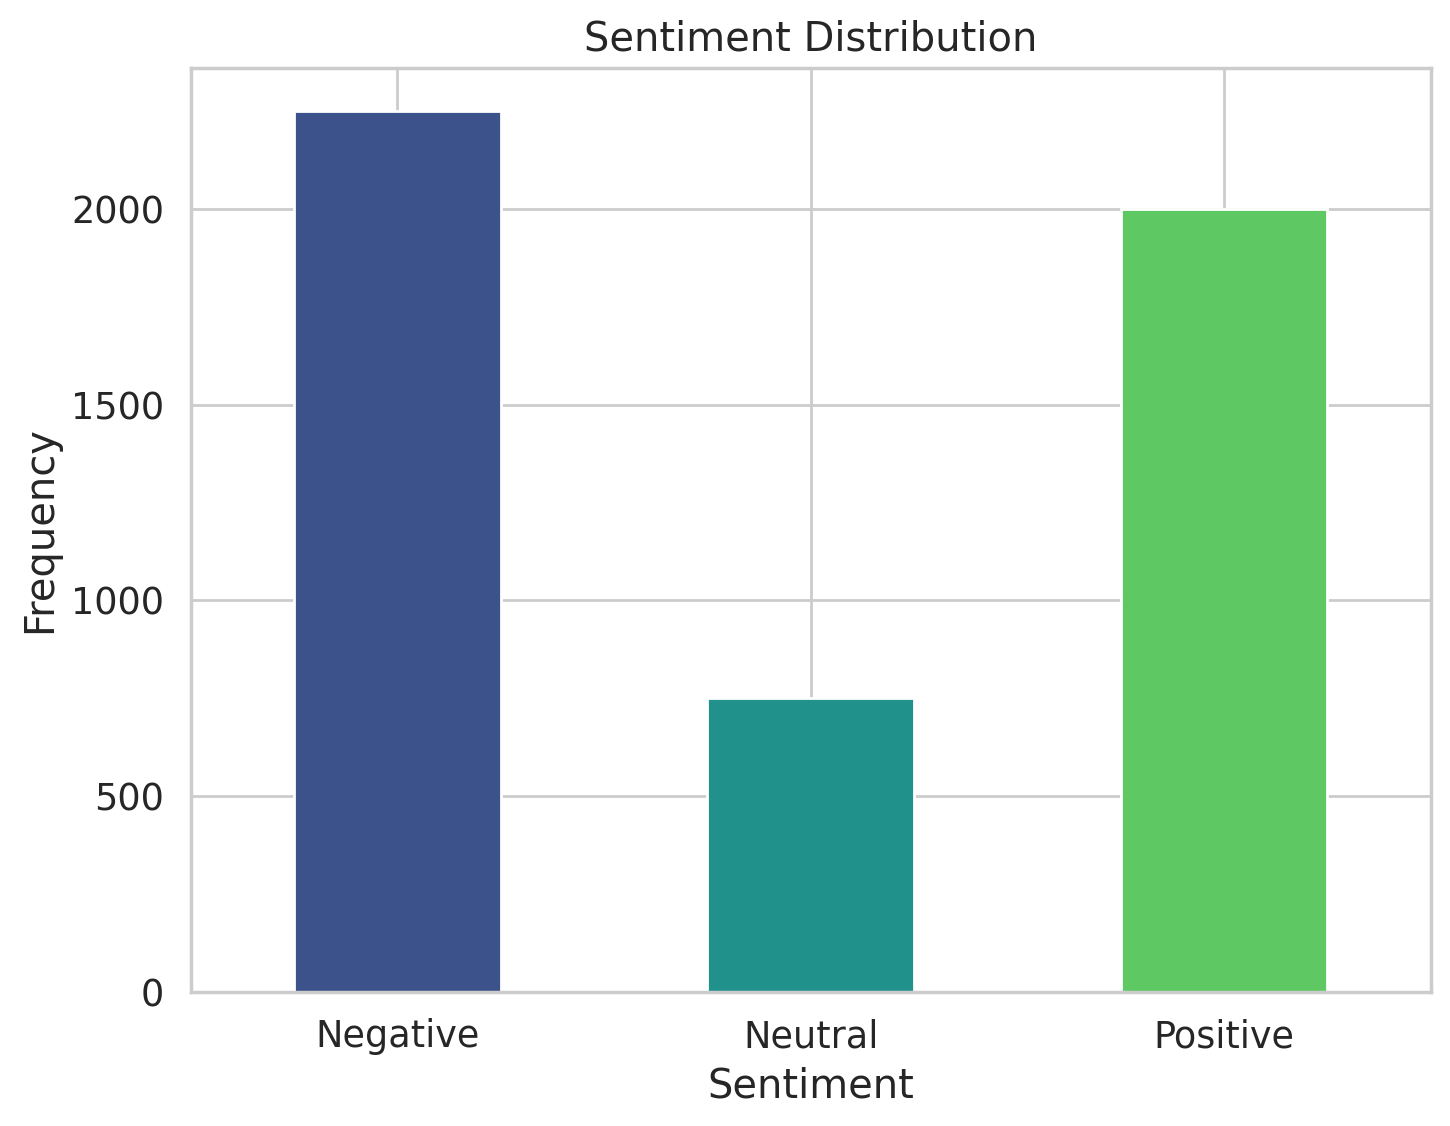

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Plot the distribution of review scores (1 to 5)
plt.figure(figsize=(10, 6))
sns.countplot(x='score', data=df, palette="viridis")
plt.title('Distribution of Review Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

# Function to convert score to sentiment
def to_sentiment(rating):
    rating = int(rating)
    # Convert to class
    if rating <= 2:
        return 0  # Negative sentiment
    elif rating == 3:
        return 1  # Neutral sentiment
    else:
        return 2  # Positive sentiment

# Apply to the dataset to create a new column 'sentiment'
df['sentiment'] = df['score'].apply(to_sentiment)

# Create a color palette similar to 'viridis' with distinct colors for sentiment
sentiment_palette = sns.color_palette("viridis", 3)  # Using first 3 colors

# Plot the sentiment distribution with the same colors as the first plot
plt.figure(figsize=(8, 6))
df['sentiment'].value_counts().sort_index().plot(kind='bar', color=sentiment_palette)

# Adding labels and title
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution')

# Set x-ticks to be sentiment classes (0=Negative, 1=Neutral, 2=Positive)
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'], rotation=0)

# Show the plot
plt.show()



### Dataset Splitting

In [ ]:
# Split the data into train, validation, and test sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)
# Print the total number of training and validation samples
print(f'Total training samples: {len(df_train)}')
print(f'Total validation samples: {len(df_val)}')

Total training samples: 3999
Total validation samples: 500


# BERT

1. Importing Required Libraries:  
   The necessary libraries like PyTorch, Transformers, and Scikit-learn are imported for data handling, model training, and evaluation.

2. Device Configuration:  
   Configures the system to use GPU if available; otherwise, it defaults to the CPU for computation.

3. Tokenizer Initialization:  
   Loads the BERT tokenizer (`bert-base-cased`) to preprocess text by tokenizing and encoding it into a format suitable for BERT.

4. Sentiment Mapping Function:  
   Defines a function (`to_sentiment`) to convert numerical ratings into sentiment classes: Negative (0), Neutral (1), and Positive (2).

5. Visualizing Sentiment Distribution:  
   Uses `seaborn` to plot a bar chart showing the distribution of sentiment classes in the dataset.

6. Dataset Class Creation:  
   Implements the `GPReviewDataset` class to preprocess and tokenize text inputs, returning tensors of input IDs, attention masks, and sentiment targets.

7. Dataset Splitting:  
   Splits the dataset into training, validation, and test sets using an 80-10-10 ratio for training and evaluation.

8. DataLoader Creation:  
   Defines a function to create PyTorch `DataLoader` objects, batching and loading data efficiently for training and validation.

9. Model Definition:  
   Creates a `SentimentClassifier` class using the BERT model with a classification head for three sentiment classes.

10. Model Optimization and Scheduling:  
    Configures the AdamW optimizer with a linear learning rate scheduler to improve model convergence during training.

11. Loss Function Setup:  
    Uses CrossEntropyLoss as the criterion to calculate the error between predicted and actual sentiment classes.

12. Training Function:  
    Implements the `train_epoch` function to train the model, update weights, and compute training accuracy and loss.

13. Evaluation Function:  
    Implements the `eval_model` function to evaluate the model on validation or test datasets, calculating accuracy and loss.




In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

# Ensure you have the necessary modules
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Function to convert score to sentiment
def to_sentiment(rating):
    if rating <= 2:
        return 0  # Negative
    elif rating == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

# Assuming df is the DataFrame with 'score' and 'content' columns
df['sentiment'] = df['score'].apply(to_sentiment)

# Plot the sentiment distribution
custom_colors = ['red', 'blue', 'green']
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='sentiment', palette=custom_colors)
plt.title('Count Plot of Sentiment Classes')
plt.xlabel('Sentiment Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])
plt.show()

# Dataset class for BERT input
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

# Split the data into train, validation, and test sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)
# Print the total number of training and validation samples
print(f'Total training samples: {len(df_train)}')
print(f'Total validation samples: {len(df_val)}')

# DataLoader creation
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=0)

# Parameters
MAX_LEN = 160
BATCH_SIZE = 16

# Create DataLoaders
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

# Build the Sentiment Classifier model using BERT
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=n_classes)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits

# Number of classes (Negative, Neutral, Positive)
model = SentimentClassifier(n_classes=3)
model = model.to(device)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * 10  # 10 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Loss function
loss_fn = nn.CrossEntropyLoss().to(device)

# Training function
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Backpropagation
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

# Evaluation function
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
for epoch in range(10):
    print(f'Epoch {epoch + 1}/10')
    train_acc, train_loss = train_accuracies[epoch], train_losses[epoch]
    val_acc, val_loss = val_accuracies[epoch], val_losses[epoch]

    # Print with 16 decimal places for train accuracy, train loss, and validation loss
    print(f'Train accuracy: {train_acc:.16f}, Train loss: {train_loss:.16f}')
    # Print with 3 decimal places for validation accuracy
    print(f'Validation accuracy: {val_acc:.3f}, Validation loss: {val_loss:.16f}')

Epoch 1/10
Train accuracy: 0.6991747936984247, Train loss: 0.7759934657216072
Validation accuracy: 0.803, Validation loss: 0.7224265169352293
Epoch 2/10
Train accuracy: 0.7871967991998000, Train loss: 0.5727445971369743
Validation accuracy: 0.825, Validation loss: 0.7158901691436768
Epoch 3/10
Train accuracy: 0.8494623655913980, Train loss: 0.4150693156421185
Validation accuracy: 0.840, Validation loss: 0.7525787218473852
Epoch 4/10
Train accuracy: 0.8984746186546637, Train loss: 0.3132077732980251
Validation accuracy: 0.868, Validation loss: 0.9414746658876538
Epoch 5/10
Train accuracy: 0.9292323080770194, Train loss: 0.2454474095720798
Validation accuracy: 0.868, Validation loss: 1.0389713186305016
Epoch 6/10
Train accuracy: 0.9469867466866718, Train loss: 0.1814035828737542
Validation accuracy: 0.900, Validation loss: 1.2368298295186833
Epoch 7/10
Train accuracy: 0.9589897474368593, Train loss: 0.1376956218285486
Validation accuracy: 0.905, Validation loss: 1.3287742384709418
Epoch 

Validation Accuracy: 0.920


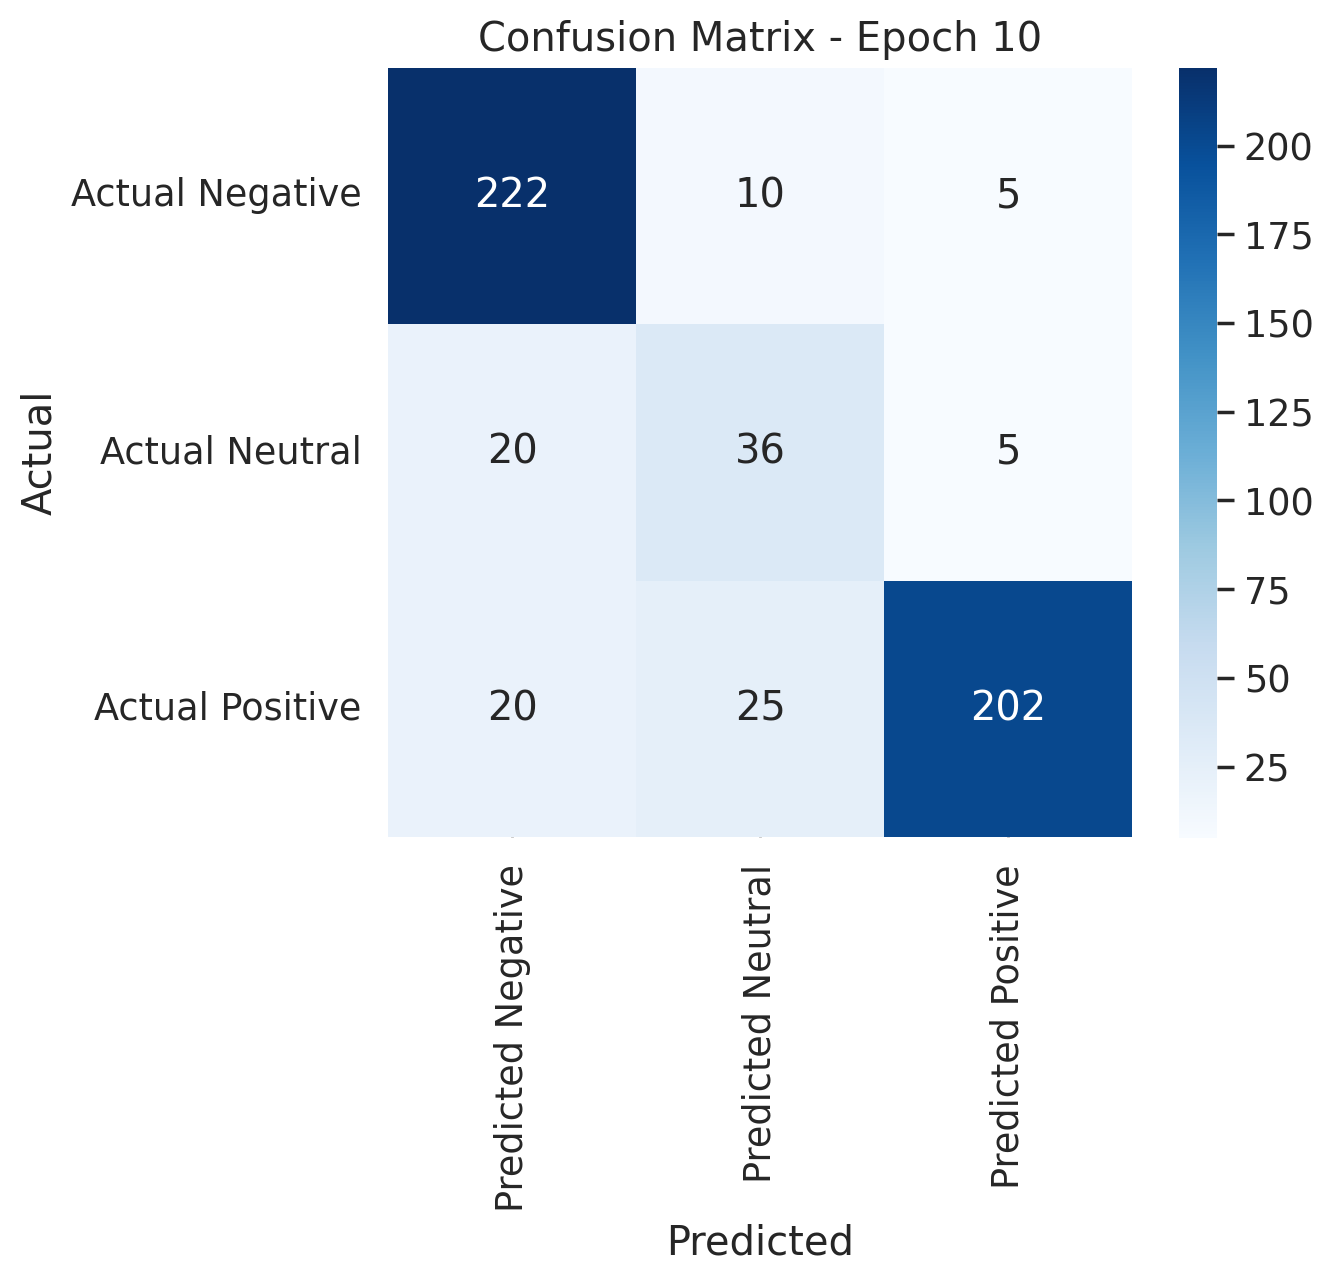

In [ ]:
# Compute confusion matrix
    cm = confusion_matrix(all_targets, all_preds, labels=[0, 1, 2])

    # Compute accuracy
    correct_predictions = np.sum(np.array(all_preds) == np.array(all_targets))
    accuracy = correct_predictions / len(all_preds) * 100

    # Print accuracy
    print(f' Validation Accuracy: {accuracy:.3f}%')

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Neutral", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Neutral", "Actual Positive"])
plt.title("Confusion Matrix - Epoch 10")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


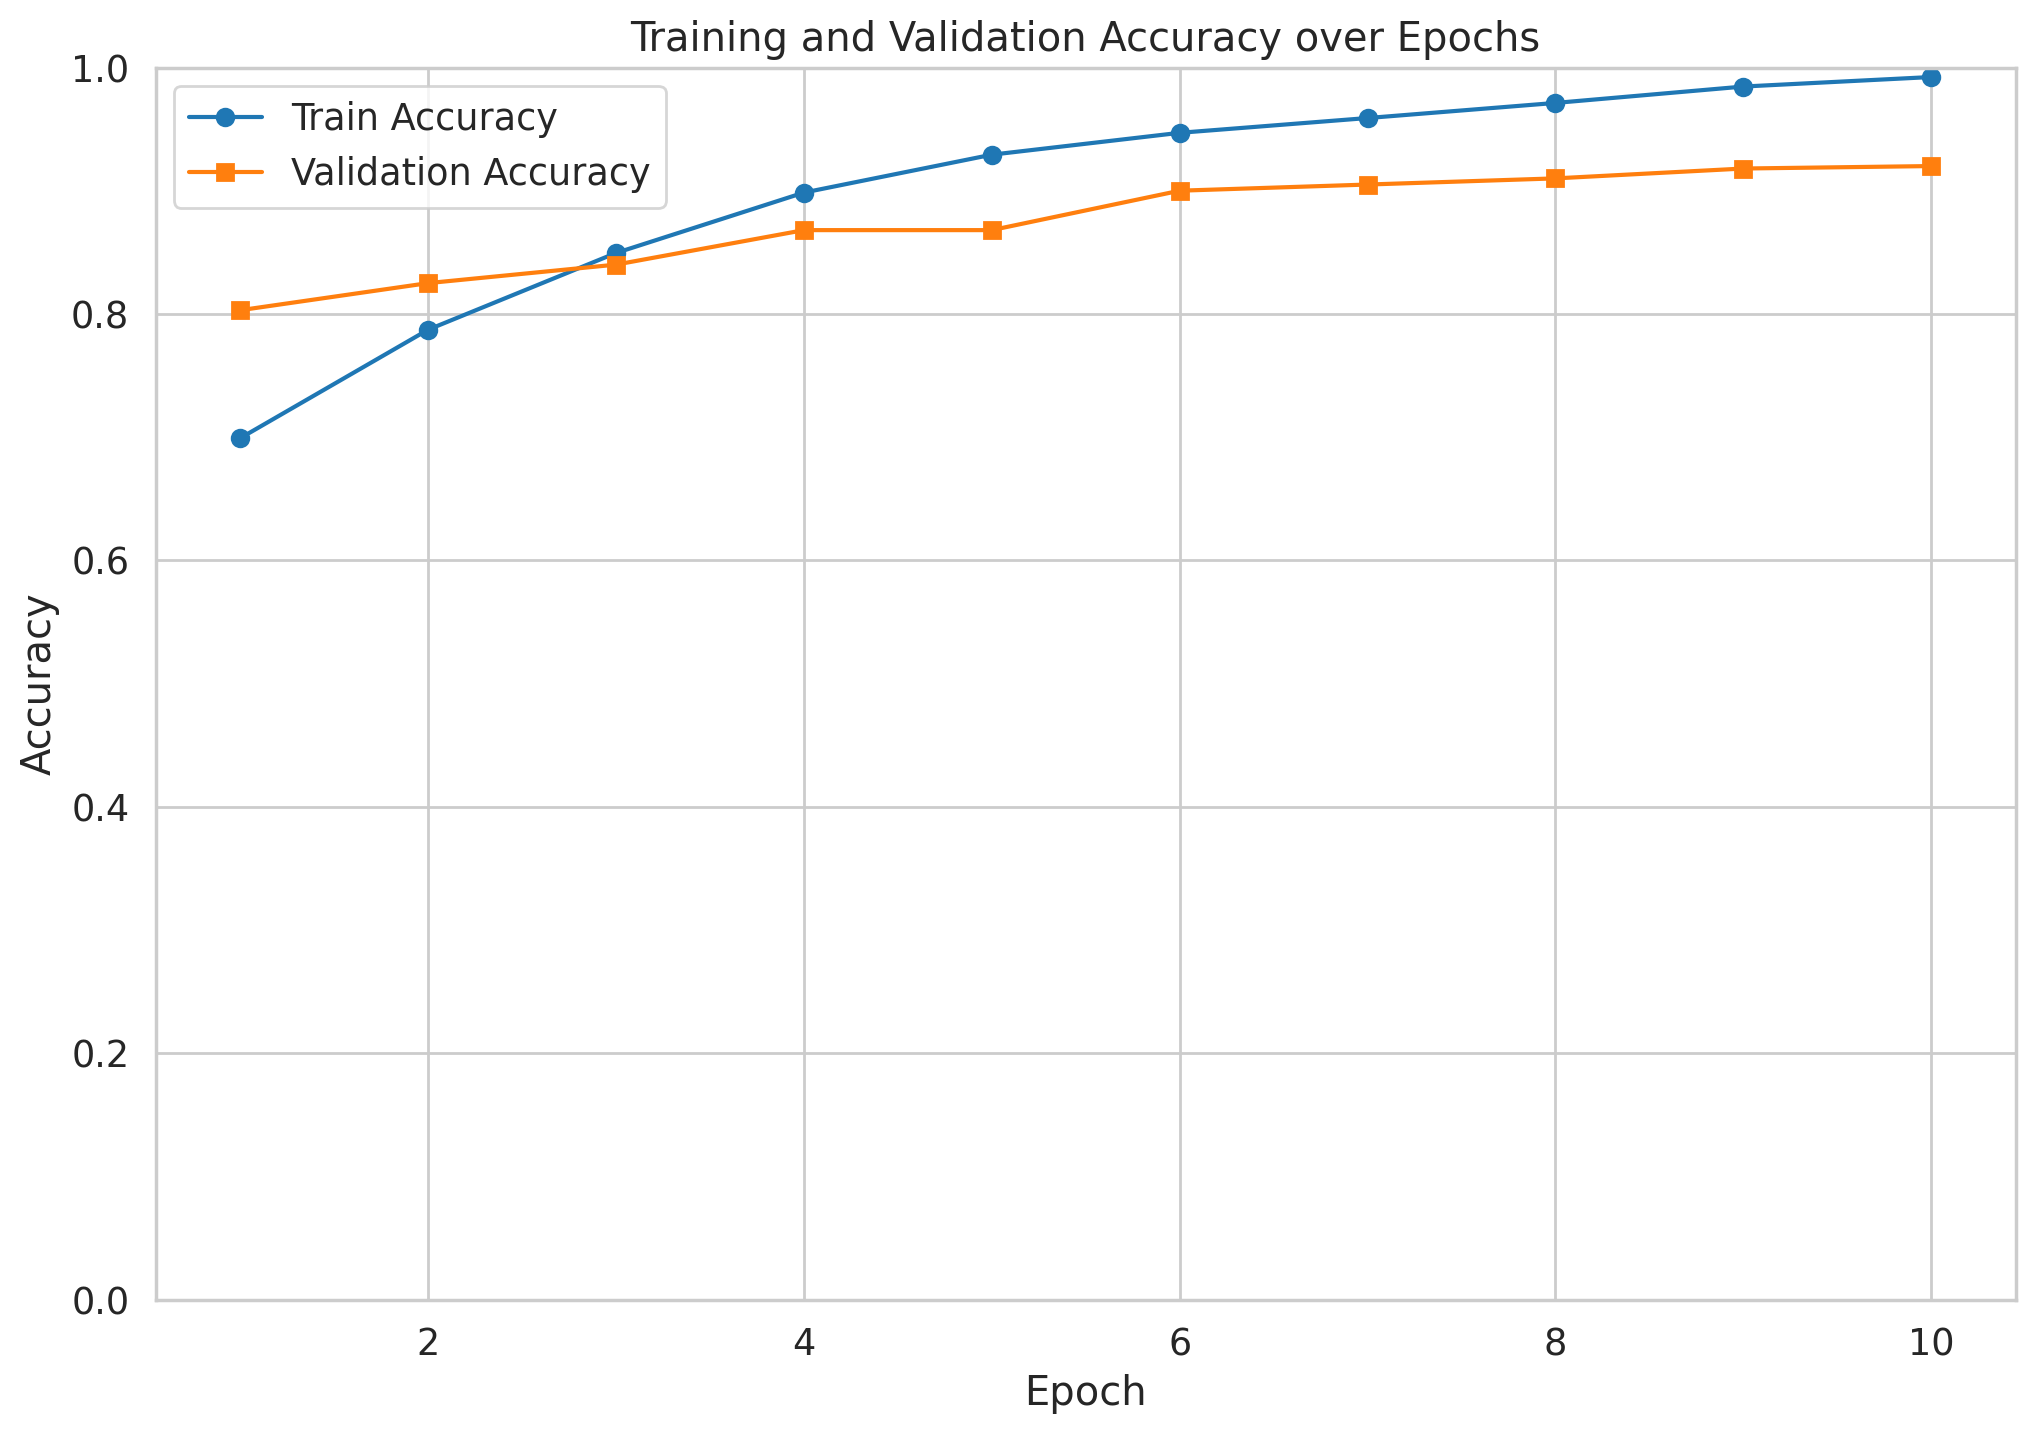

In [ ]:
import matplotlib.pyplot as plt

# Data for epochs, training accuracy, and validation accuracy
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
train_acc = [0.6991747936984247, 0.7871967991998000, 0.8494623655913980, 0.8984746186546637,
             0.9292323080770194, 0.9469867466866718, 0.9589897474368593, 0.9712428107026758,
             0.9845398706900585, 0.9922699353450293]
val_acc = [0.803, 0.825, 0.840, 0.868, 0.868, 0.900, 0.905, 0.910, 0.918, 0.920]

# Plot training and validation accuracy with different colors
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o', color='tab:blue')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='s', color='tab:orange')

# Add title and labels
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Set the y-axis range from 0 to 1 (percentage scale)
plt.ylim([0, 1])

# Display the plot
plt.grid(True)
plt.show()


### **Prediction on Dataset**

In [ ]:
import torch
from transformers import BertTokenizer

# Function to predict sentiment of a single review
def predict_sentiment(review_text, model, tokenizer, max_len=160):
    # Tokenize the input text using the BERT tokenizer
    encoding = tokenizer.encode_plus(
        review_text,
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=max_len,       # Pad/truncate to max length
        padding='max_length',     # Pad to max length
        truncation=True,          # Truncate to max length
        return_attention_mask=True,
        return_tensors='pt'       # Return as PyTorch tensors
    )

    # Extract the input IDs and attention mask
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Put the model in evaluation mode
    model.eval()

    # Make prediction without computing gradients
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs

        # Get the predicted class (the index with the highest logit)
        _, predicted_class = torch.max(logits, dim=1)

    # Map predicted class to sentiment label
    sentiment_classes = ['negative', 'neutral', 'positive']

    return sentiment_classes[predicted_class.item()]

# Example usage
review_text = "Can login with facebook because there is an issue with login implementation. Uninstalling"

# Get prediction for the review
predicted_sentiment = predict_sentiment(review_text, model, tokenizer)
print(f"Review: {review_text}")
print(f"Predicted Sentiment: {predicted_sentiment}")


Review: Can login with facebook because there is an issue with login implementation. Uninstalling
Predicted Sentiment: negative


In [ ]:
import torch
from transformers import BertTokenizer

# Function to predict sentiment of a single review
def predict_sentiment(review_text, model, tokenizer, max_len=160):
    # Tokenize the input text using the BERT tokenizer
    encoding = tokenizer.encode_plus(
        review_text,
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=max_len,       # Pad/truncate to max length
        padding='max_length',     # Pad to max length
        truncation=True,          # Truncate to max length
        return_attention_mask=True,
        return_tensors='pt'       # Return as PyTorch tensors
    )

    # Extract the input IDs and attention mask
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Put the model in evaluation mode
    model.eval()

    # Make prediction without computing gradients
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs

        # Get the predicted class (the index with the highest logit)
        _, predicted_class = torch.max(logits, dim=1)

    # Map predicted class to sentiment label
    sentiment_classes = ['negative', 'neutral', 'positive']

    return sentiment_classes[predicted_class.item()]

# Example usage
review_text = "This product is amazing! It has helped me so much."

# Get prediction for the review
predicted_sentiment = predict_sentiment(review_text, model, tokenizer)
print(f"Review: {review_text}")
print(f"Predicted Sentiment: {predicted_sentiment}")


Review: This product is amazing! It has helped me so much.
Predicted Sentiment: positive


# **DistilBERT**

DistilBERT (Distilled BERT) is a smaller, faster, and lighter version of BERT, designed to maintain most of BERT's performance while being computationally efficient.

DistilBERT removes some redundant layers from BERT (e.g., uses 6 transformer layers instead of 12 in BERT base).
It retains BERT's tokenization and embeddings, ensuring compatibility with tasks designed for BERT.


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set the model name
MODEL_NAME = 'distilbert-base-uncased'

# Build the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

# Function to convert score to sentiment
def to_sentiment(rating):
    if rating <= 2:
        return 0  # Negative
    elif rating == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

# Assuming df is the DataFrame with 'score' and 'content' columns
df['sentiment'] = df['score'].apply(to_sentiment)

# Dataset class for DistilBERT input
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

# Split the data into train, validation, and test sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

# DataLoader creation
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=0)

# Parameters
MAX_LEN = 160
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

# Build the Sentiment Classifier model using DistilBERT
class SentimentClassifierDistilBERT(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifierDistilBERT, self).__init__()
        self.distilbert = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=n_classes)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.distilbert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits

# Instantiate model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentClassifierDistilBERT(n_classes=3)
model = model.to(device)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * 10  # 10 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Loss function
loss_fn = nn.CrossEntropyLoss().to(device)

# Training function
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Backpropagation
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

# Evaluation function
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Example usage: Model Training
# This loop should run for each epoch. It's just an example for the training phase:
for epoch in range(10):  # 10 epochs as an example
    print(f'Epoch {epoch + 1}/10')

    # Training
    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train accuracy: {train_acc:.4f}, Train loss: {train_loss:.4f}')

    # Validation
    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
    print(f'Validation accuracy: {val_acc:.4f}, Validation loss: {val_loss:.4f}')

    # Testing
    test_acc, test_loss = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
    print(f'Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Train accuracy: 0.7242, Train loss: 0.7091
Validation accuracy: 0.7620, Validation loss: 0.6418
Test accuracy: 0.7520, Test loss: 0.6926
Epoch 2/10
Train accuracy: 0.8067, Train loss: 0.4994
Validation accuracy: 0.7680, Validation loss: 0.6135
Test accuracy: 0.7420, Test loss: 0.6828
Epoch 3/10
Train accuracy: 0.8550, Train loss: 0.3822
Validation accuracy: 0.7400, Validation loss: 0.7760
Test accuracy: 0.7600, Test loss: 0.8289
Epoch 4/10
Train accuracy: 0.9012, Train loss: 0.2732
Validation accuracy: 0.7400, Validation loss: 0.8734
Test accuracy: 0.7460, Test loss: 0.9435
Epoch 5/10
Train accuracy: 0.9375, Train loss: 0.1977
Validation accuracy: 0.7360, Validation loss: 1.0649
Test accuracy: 0.7540, Test loss: 1.0794
Epoch 6/10
Train accuracy: 0.9530, Train loss: 0.1551
Validation accuracy: 0.7440, Validation loss: 1.1329
Test accuracy: 0.7460, Test loss: 1.2119
Epoch 7/10
Train accuracy: 0.9637, Train loss: 0.1281
Validation accuracy: 0.7400, Validation loss: 1.2090
Test 

Accuracy: 73.00%


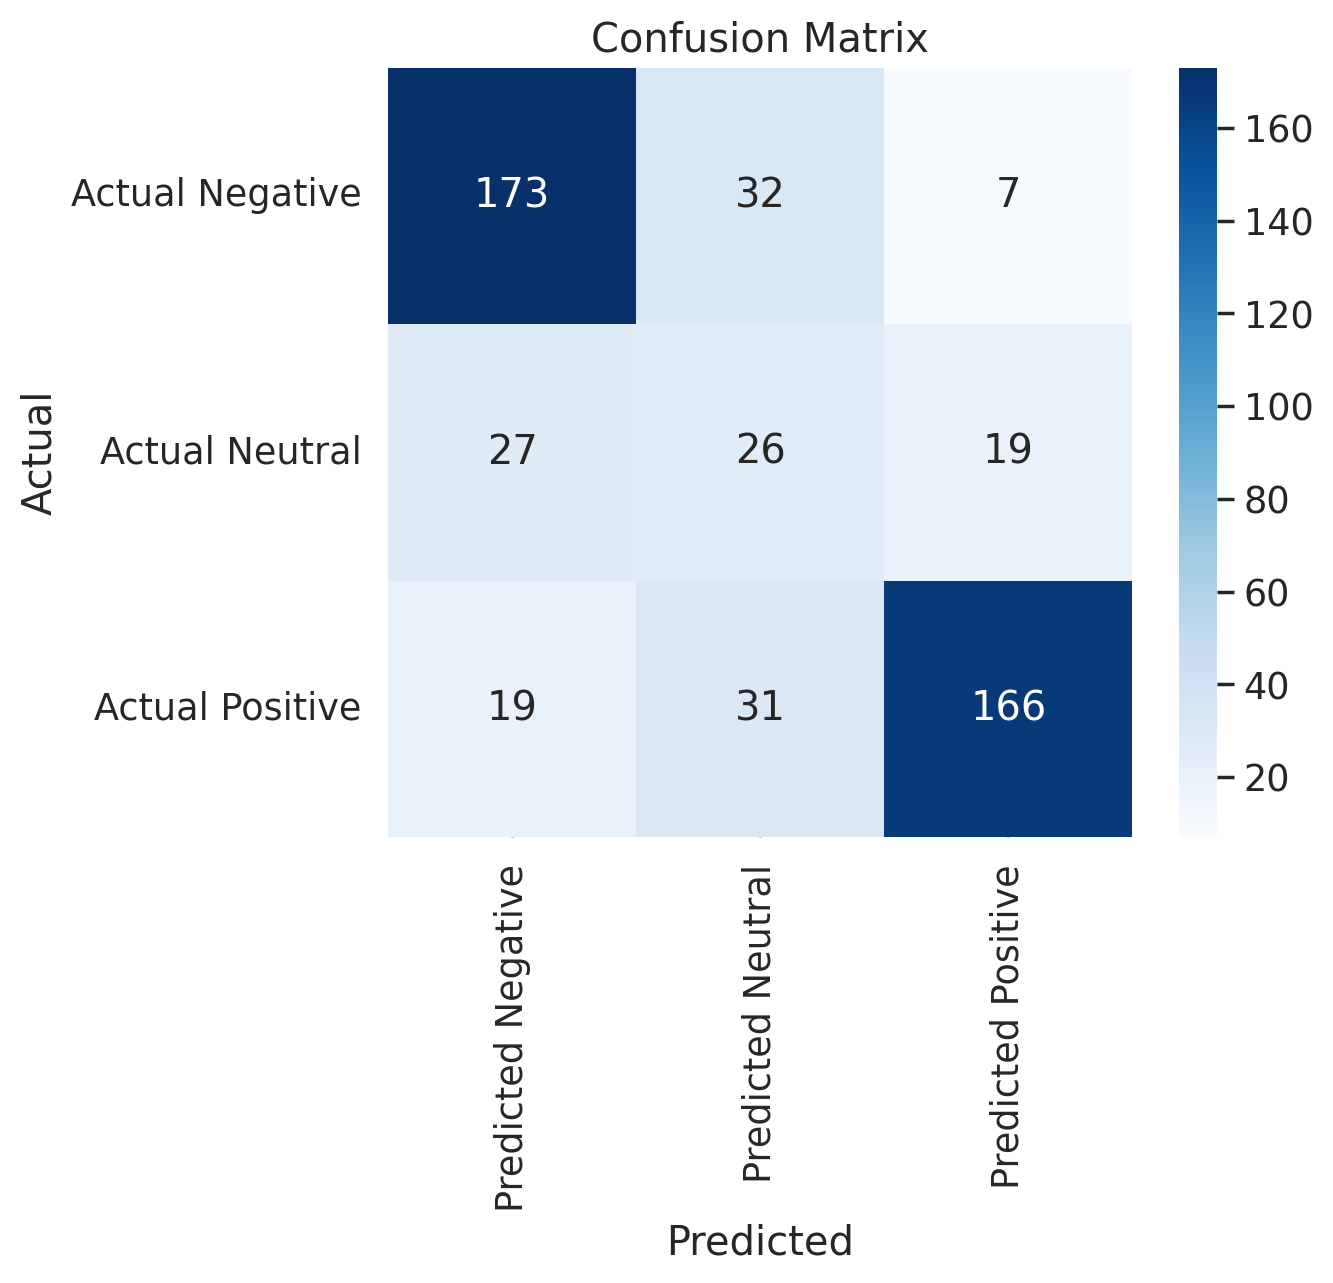

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to compute the confusion matrix and accuracy
def plot_confusion_matrix_and_accuracy(model, data_loader, device, n_classes=3):
    model = model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_targets, all_preds, labels=[0, 1, 2])

    # Compute accuracy
    correct_predictions = np.sum(np.array(all_preds) == np.array(all_targets))
    accuracy = correct_predictions / len(all_preds) * 100

    # Print accuracy
    print(f'Accuracy: {accuracy:.2f}%')

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Negative", "Predicted Neutral", "Predicted Positive"],
                yticklabels=["Actual Negative", "Actual Neutral", "Actual Positive"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Example usage:
plot_confusion_matrix_and_accuracy(model, val_data_loader, device, n_classes=3)


In [ ]:
def predict_sentiment_distilbert(review_text, model, tokenizer, max_len=160):
    # Tokenize the review text
    encoding = tokenizer.encode_plus(
        review_text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        # Forward pass: get logits from model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # outputs is a tuple (logits, hidden_states)
        logits = outputs[0]  # Access the logits directly from the output tuple

        # logits is of shape (batch_size, num_classes), and here batch_size is 1
        # Get predicted class (index of the max logit)
        predicted_class = torch.argmax(logits, dim=-1)  # Use -1 to ensure the correct dimension is selected

    sentiment_classes = ['negative', 'neutral', 'positive']
    return sentiment_classes[predicted_class.item()]

# Example usage for prediction
review_text = "This product is amazing, works perfectly!"
predicted_sentiment = predict_sentiment_distilbert(review_text, model, tokenizer)
print(f"Review: {review_text}")
print(f"Predicted Sentiment: {predicted_sentiment}")


Review: This product is amazing, works perfectly!
Predicted Sentiment: positive


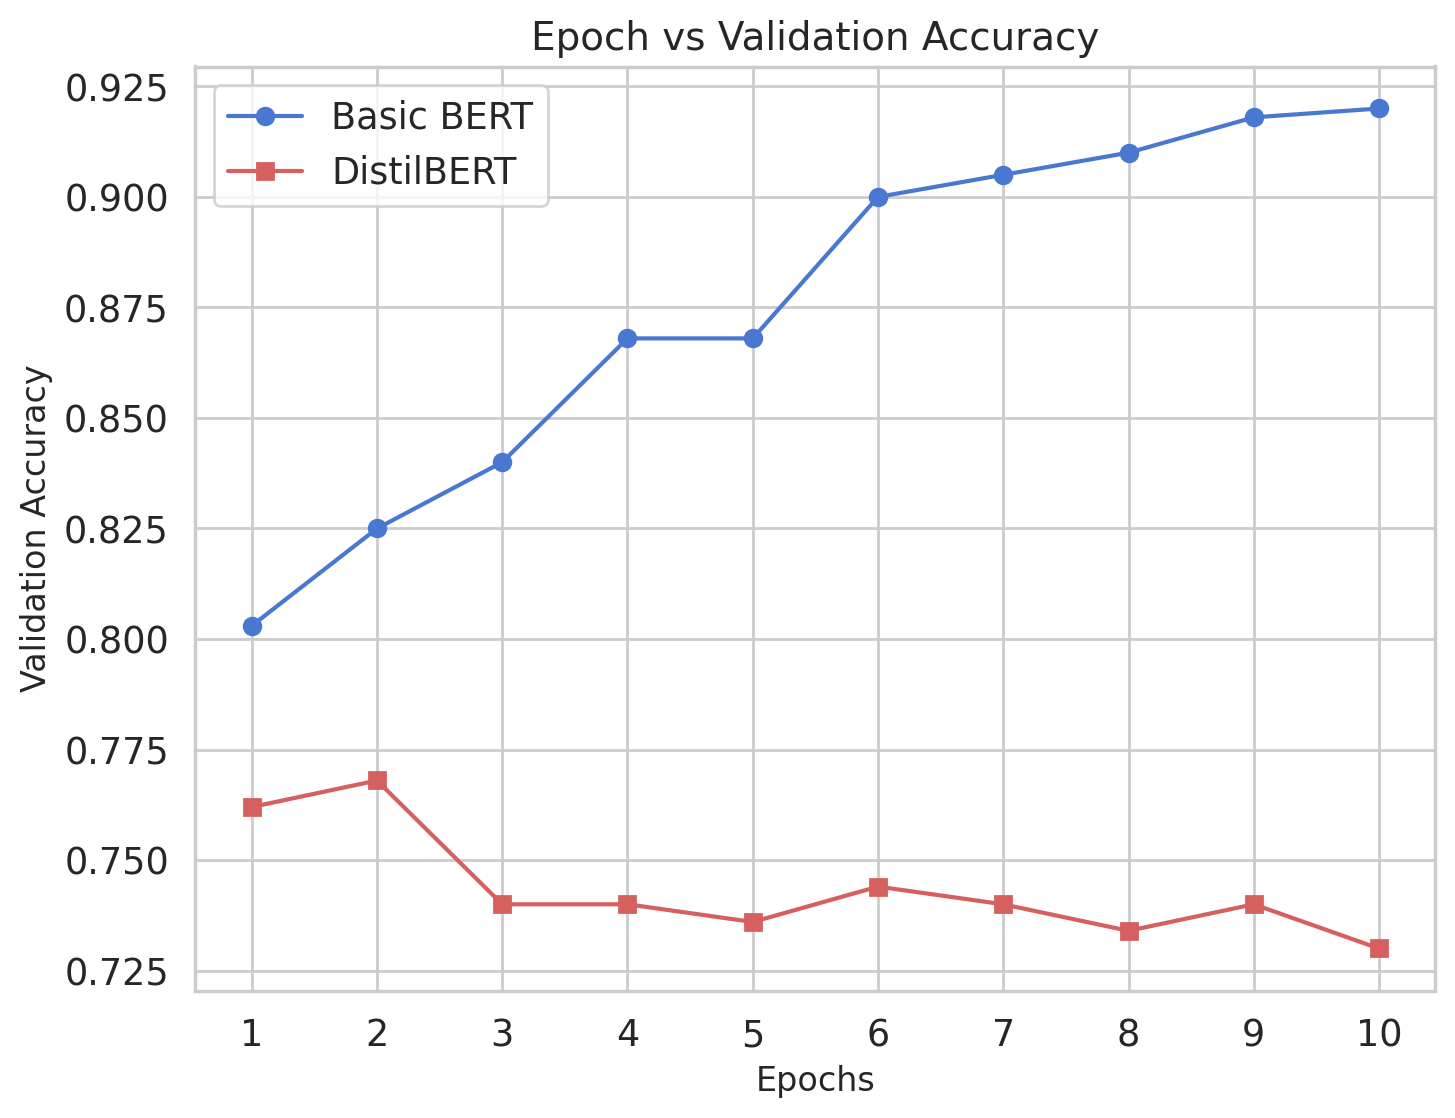

In [ ]:
import matplotlib.pyplot as plt

# Basic BERT validation accuracy for each epoch
basic_bert_val_acc = [
    0.803, 0.825, 0.840, 0.868, 0.868, 0.900, 0.905, 0.910, 0.918, 0.920
]

# DistilBERT validation accuracy for each epoch
distilbert_val_acc = [
    0.7620, 0.7680, 0.7400, 0.7400, 0.7360, 0.7440, 0.7400, 0.7340, 0.7400, 0.7300
]

# Epochs (from 1 to 10)
epochs = list(range(1, 11))

# Plotting the graph
plt.figure(figsize=(8, 6))

# Plot for Basic BERT
plt.plot(epochs, basic_bert_val_acc, label="Basic BERT", color="b", marker="o")

# Plot for DistilBERT
plt.plot(epochs, distilbert_val_acc, label="DistilBERT", color="r", marker="s")

# Adding titles and labels
plt.title("Epoch vs Validation Accuracy", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Validation Accuracy", fontsize=12)

# Adding grid, legend, and showing the plot
plt.grid(True)
plt.legend()
plt.xticks(epochs)  # Ensure that all epochs are marked on x-axis

# Show the plot
plt.show()
